In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import astropy_mpl_style, simple_norm
plt.style.use(astropy_mpl_style)

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from photutils import aperture_photometry, find_peaks
from photutils.aperture import CircularAperture, CircularAnnulus

In [4]:
path = "/home/jeje/Dokumente/Masterthesis/ZirkumstellareScheibe_HD142527/"

In [5]:
image_data = fits.getdata(path + "sci_cyc129_normft_1.fits", ext=0)
fits.info(path + "sci_cyc129_normft_1.fits")

Filename: /home/jeje/Dokumente/Masterthesis/ZirkumstellareScheibe_HD142527/sci_cyc129_normft_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     831   (1024, 1024, 4)   float32   


In [6]:
#vertical flip image data to have the same convention as ds9
axis2fl=int(image_data.ndim-2)
#print('axis to flip:',axis2fl)
img_ori = np.flip(image_data, axis2fl)

In [7]:
pol, w, h = img_ori.shape
print(pol, w, h)

4 1024 1024


In [8]:
width = 200
heigth = 200
img_cropped = img_ori[:, int((w-width)/2):int(w - (w-width)/2), int((h-heigth)/2):int(h - (h-heigth)/2)]

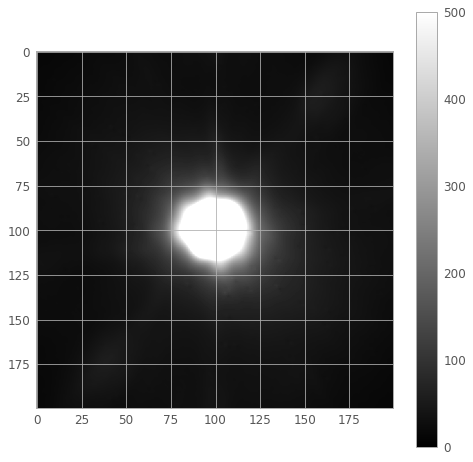

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(img_cropped[0,:,:], cmap='gray', vmin=0, vmax=500)
plt.colorbar()

[[100.0, 100.0, 30204.54296875]]


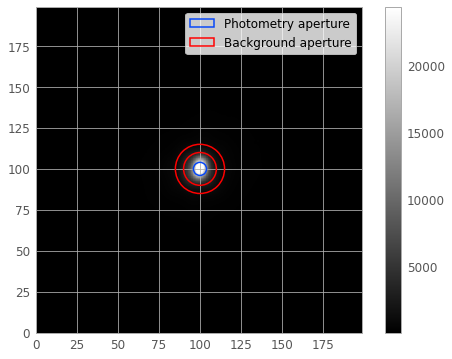

[(100.0, 100.0)]


In [10]:
int1 = img_cropped[0,:,:]
tbl = find_peaks(int1, 500, box_size=50)
norm = simple_norm(int1, 'power', percent=99.9)
plt.imshow(int1, cmap='gray', norm = norm)
pe = np.array(tbl['peak_value'])
pe_x = np.array(tbl['x_peak'])
pe_y = np.array(tbl['y_peak'])
peaks = np.array((pe_x, pe_y, pe)).T
peaks = peaks.tolist()
peaks = sorted(peaks, key=lambda t: t[2], reverse=True)
print(peaks)
positions = [(peaks[0][0], peaks[0][1])] 
apertures = CircularAperture(positions, r=4.)
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)
apertures.plot(color ='#0547f9', lw=1.5, label='Photometry aperture')
annulus_aperture.plot(color = 'red', lw=1.5, label='Background aperture')
plt.xlim(0, int1.shape[1]-1)
plt.ylim(0, int1.shape[0]-1)
plt.legend()
plt.colorbar()

plt.show()
phot_table = aperture_photometry(int1, apertures)
aperture = np.array(phot_table['aperture_sum'])
print(positions)

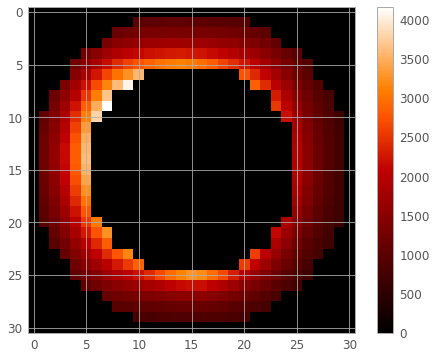

In [11]:
annulus_masks = annulus_aperture.to_mask(method='center')
print(annulus_masks[0])
annulus_data = annulus_masks[0].multiply(int1)

plt.figure()
plt.imshow(annulus_data, interpolation='nearest')
plt.colorbar()

In [12]:
mask = annulus_masks[0].data
annulus_data_1d = annulus_data[mask > 0]
annulus_data_1d.shape

(392,)

In [15]:
# Flux from the aperture (like from the report (gisin))

spixel_star = sum(annulus_data_1d)/annulus_data_1d.shape[0]
print(spixel_star)

f_ap_star = aperture - apertures.area*spixel_star
print(f_ap_star)

1686.3219501728913
[1083036.83688844]


We now want to calculate the S/N from the ghost to find then the ideal aperture radius. We use this radius to determine how much brighter the star is compared to the ghost.

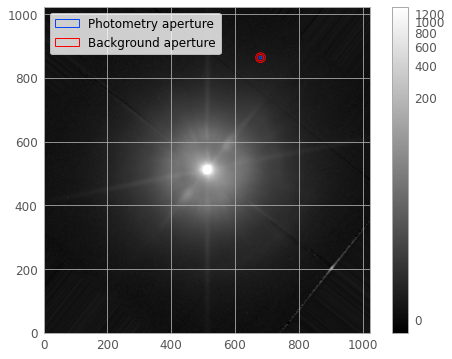

[(680.0, 863.0)]
4.786538


In [16]:
int1 = image_data[0,:,:]

norm = simple_norm(int1, 'log', percent=99.9)
plt.imshow(int1, cmap='gray', norm= norm)
#plt.imshow(int1, cmap='gray', vmin=0, vmax=200)
positions_gh = [(680.0, 863.0)] 
apertures_gh = CircularAperture(positions_gh, r=4.)
annulus_gh = CircularAnnulus(positions_gh, r_in=10, r_out=15)
apertures_gh.plot(color ='#0547f9', lw=1.0, label='Photometry aperture')
annulus_gh.plot(color = 'red', lw=1.0, label='Background aperture')
plt.xlim(0, int1.shape[1]-1)
plt.ylim(0, int1.shape[0]-1)
plt.legend()
plt.colorbar()

plt.show()
phot_table_gh = aperture_photometry(int1, apertures_gh)
aperture_gh = np.array(phot_table_gh['aperture_sum'])
print(positions_gh)
print(int1[863, 680])


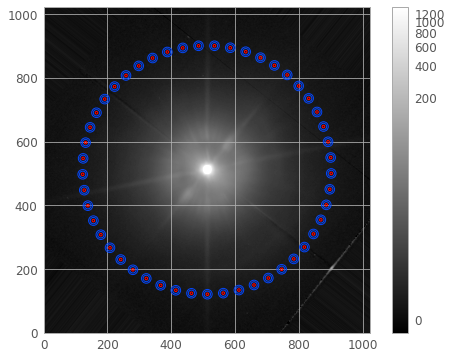

In [17]:
# We want to create an aperture and an annulus for several points on a circle around the star at the same radius 
# where the ghost is

## Find the position of the star
tbl = find_peaks(int1, 500, box_size=50)
pe = np.array(tbl['peak_value'])
pe_x = np.array(tbl['x_peak'])
pe_y = np.array(tbl['y_peak'])
peaks = np.array((pe_x, pe_y, pe)).T
peaks = peaks.tolist()
peaks = sorted(peaks, key=lambda t: t[2], reverse=True)
star_position = [(peaks[0][0], peaks[0][1])] 

plt.imshow(int1, cmap='gray', norm = norm)

## Position of the ghost in Polar coordinates, where the star is the origin
rad = np.sqrt((positions_gh[0][0]-star_position[0][0])**2 + (positions_gh[0][1]-star_position[0][1])**2)
phi_gh = np.arctan((positions_gh[0][1]-star_position[0][1])/(positions_gh[0][0]-star_position[0][0]))

circ = CircularAperture(star_position, r=round(rad, 0))

phi = np.linspace(0, 2*np.pi, 50) + phi_gh
x_circ = star_position[0][0] + rad* np.cos(phi)
y_circ = star_position[0][1] + rad* np.sin(phi)
circ_positions = []
for i in range(len(x_circ)-1):
    circ_positions.append((x_circ[i],y_circ[i]))

circles = CircularAperture(circ_positions, r=4.)
circles.plot(color ='r', lw=1.0)
annulus_circles = CircularAnnulus(circ_positions, r_in=10, r_out=15)
annulus_circles.plot(color ='#0547f9', lw=1.0)

#circ.plot(color ='y', lw=1.0)
plt.xlim(0, int1.shape[1]-1)
plt.ylim(0, int1.shape[0]-1)
#plt.legend()
plt.colorbar()

#plt.savefig('Aperture_photometry.pdf')
plt.show()

In [18]:
phot_table_circ = aperture_photometry(int1, circles)
aperture_circ = np.array(phot_table_circ['aperture_sum'])
print(aperture_circ)

[198.05786501  34.02327756  35.91870706  35.82166451  28.88357068
  34.24412578  34.16006868  31.85438826  38.02301444  37.42403618
  34.10693979  35.82389844  36.83159421  40.71152865  37.55531269
  39.99612014  43.14752774  55.62792067  43.2290685   38.0085267
  39.80574506  43.0341894   39.25906848  33.71210978  28.6325594
  35.49457965  32.44525984  36.14108136  63.4866206   40.56716661
  40.24991013  42.69569882  43.61037118  43.8979793   48.15700864
  30.0044584   45.51987822  47.09432586  47.34303489  49.93378709
  46.66288122  48.90121431  53.31739962  43.25158368  45.71830073
  45.03279416  50.13277134  54.51169972  52.51980369]


(392,)

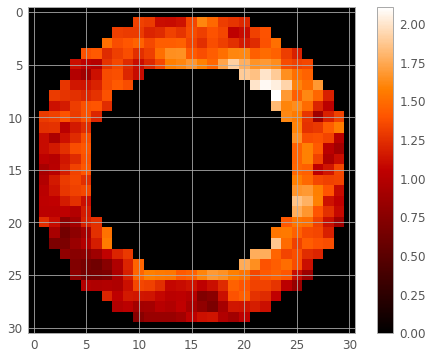

In [173]:
annulus_circ_masks = annulus_circles.to_mask(method='center')
print(annulus_circ_masks[0])
annulus_circ_data = annulus_circ_masks[0].multiply(int1)

plt.figure()
plt.imshow(annulus_circ_data, interpolation='nearest')
plt.colorbar()

mask_circ = annulus_circ_masks[0].data
annulus_circ_data_1d = annulus_circ_data[mask_circ > 0]
annulus_circ_data_1d.shape

In [19]:
signalperpix = []
f_ap = []

annulus_circ_masks = annulus_circles.to_mask(method='center')
for i in range(len(x_circ)-1):
    annulus_circ_data = annulus_circ_masks[i].multiply(int1)

    #plt.figure()
    #plt.imshow(annulus_circ_data, interpolation='nearest')
    #plt.colorbar()

    mask_circ = annulus_circ_masks[i].data
    annulus_circ_data_1d = annulus_circ_data[mask_circ > 0]
    annulus_circ_data_1d.shape

    # Flux from the apertures (like from the report (gisin))
    
    spixel = sum(annulus_circ_data_1d)/annulus_circ_data_1d.shape[0]
    signalperpix.append(spixel)
    
    f_ap.append(aperture_circ[i] - circles.area*spixel)


f_ap = np.array(f_ap)
#print(signalperpix)
print(f_ap)

[ 1.33730036e+02 -3.30539316e+00 -1.43972023e+00 -5.02729966e+00
 -8.82676551e+00 -7.93684586e-01  6.77455687e-01 -3.97701705e+00
  2.16765750e+00  1.58509428e+00 -2.07343736e+00 -3.25796372e+00
 -5.76216538e-01 -1.32702856e-01 -1.61030868e+00  2.02006903e-01
 -2.36895288e+00  2.51164602e-01  1.43534605e+00 -4.45532978e+00
  1.23578289e+00  2.63072571e+00 -3.15146554e-01 -2.82438181e+00
 -2.78319129e+00  5.67241976e-01 -1.39767710e+00 -3.07454065e+00
  1.12237104e+01  1.73800118e+00 -8.98716598e-01  2.91726307e+00
 -7.92166265e-01 -1.08951293e+00 -2.67203387e+00 -1.20231825e+01
 -1.13087389e+00  7.28390918e-01  2.87547248e-01  1.49015812e+00
 -1.75172001e+00  3.27214306e-01 -3.87042791e+00 -2.27006004e+00
 -1.27908196e+00 -2.18973732e+00  1.41787539e-01  3.72799647e-02
  8.76380762e-01]


In [175]:
fmean = sum(f_ap[1:])/(len(f_ap))
print(fmean)
print(len(f_ap))

sigma = np.sqrt(1/(len(f_ap)-1) * sum((f_ap[1:] - fmean)**2))
print(sigma)

SN = (f_ap[0]-fmean)/sigma
print(SN)

-0.9732047687883585
49
3.230354155191319
41.69921771008162


How much less bright is the ghost?

In [184]:
ratio = f_ap[0]/f_ap_star
print(ratio)

[0.00011452]
